In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sp_bam = pd.read_excel("data-files/밤고구마.xlsx", engine='openpyxl')
sp_ho = pd.read_excel("data-files/호박고구마.xlsx", engine='openpyxl')


In [151]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7229 entries, 0 to 7228
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     7229 non-null   object 
 1   거래단위     7229 non-null   object 
 2   평균가격     7229 non-null   object 
 3   총거래물량    7229 non-null   float64
 4   총거래금액    7229 non-null   int64  
 5   도매시장     7229 non-null   object 
 6   도매법인     7229 non-null   object 
 7   품목       7229 non-null   object 
 8   품종       7229 non-null   object 
 9   산지-광역시도  7229 non-null   object 
 10  산지-시군구   7229 non-null   object 
 11  등급       7229 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 677.8+ KB


In [4]:
sp_bam['DATE'] = pd.to_datetime(sp_bam['DATE'], format='%Y-%m')

In [6]:
sp_bam['산지-광역시도'].unique()

array(['전라북도', '충청남도', '부산', '전라남도', '경기도', '충청북도', '-', '전북', '전남', '강원',
       '충남', '경북', '경상남도', '경기', '충북', '경남', '서울특별시', '부산광역시', '광주',
       '경상북도', '강원도', '인천', '인천광역시', '세종시', '광주광역시', '서울', '울산', '대구',
       '울산광역시', '대전광역시', '제주', '대구광역시', '제주도', '대전', '필리핀'], dtype=object)

In [7]:
sp_bam['도매시장'].unique()

array(['서울가락도매', '부산반여도매', '광주각화도매', '전주도매시장', '대구북부도매', '인천삼산도매',
       '구리도매시장', '안산도매시장', '인천구월도매', '원주도매시장', '서울강서도매', '안양도매시장',
       '창원내서도매시장', '안동도매시장', '강릉도매시장', '진주도매시장', '천안도매시장', '대전노은도매',
       '구미도매시장', '울산도매시장', '순천도매시장', '광주서부도매', '청주도매시장', '부산엄궁도매',
       '수원도매시장', '충주도매시장', '포항도매시장', '정읍도매시장', '익산도매시장', '춘천도매시장',
       '창원팔용도매시장', '대전오정도매'], dtype=object)

In [8]:
# 산지-광역시도 기준 디렉토리

region_sum = {
    '충남': '충청남도', 
    '강원': '강원도', 
    '제주':'제주도', 
    '전남' : '전라남도',
    '전북' : '전라북도', 
    '강원' : '강원도',
    '충북' : '충청북도',
    '부산' : '부산광역시',
    '경남' : '경상남도',
    '서울' : '서울특별시',
    '광주' : '광주광역시', 
    '경북' : '경상북도',
    '경기' : '경기도',
    '인천' : '인천광역시',
    '대구' : '대구광역시',
    '울산' : '울산광역시',
    '대전' : '대전광역시'
}

In [9]:
# 시각화 하기 위해서 평균가격, 총거래물량, 도매시장, 산지-광역시도 컬럼만 가져오기

sp_bam['평균가격'] = pd.to_numeric(sp_bam['평균가격'], errors='coerce')
sp_bam['총거래물량'] = pd.to_numeric(sp_bam['총거래물량'], errors='coerce')


sp_bam_cleaned = sp_bam.dropna(subset=['평균가격', '총거래물량', '도매시장', '산지-광역시도'])


# 가중치
sp_bam_cleaned['weighted_price'] = (
    sp_bam_cleaned['평균가격'] * sp_bam_cleaned['총거래물량']
)


# 산지-광역시도 데이터를 위에서 만든 기준 디렉토리를 이용하여 변경
# 충북 = 충청북도, 충남 = 충청남도 등

sp_bam_cleaned['산지-광역시도'] = sp_bam_cleaned['산지-광역시도'].replace(region_sum)


# 도매시장별로 그룹화
weighted_avg_market = (
    sp_bam_cleaned.groupby(['DATE', '도매시장']).apply(
        lambda g: g['weighted_price'].sum() / g['총거래물량'].sum()
    ).reset_index(name='가중평균가격')
)

# 광역시도별로 그룹화
weighted_avg_ragion = (
    sp_bam_cleaned.groupby(['DATE', '산지-광역시도'])
    .apply(lambda g: g['weighted_price'].sum() / g['총거래물량'].sum())
    .reset_index(name='가중평균가격')
)

C:\Users\human\AppData\Local\Temp\ipykernel_3252\170454458.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_bam_cleaned['weighted_price'] = (
C:\Users\human\AppData\Local\Temp\ipykernel_3252\170454458.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_bam_cleaned['산지-광역시도'] = sp_bam_cleaned['산지-광역시도'].replace(region_sum)
C:\Users\human\AppData\Local\Temp\ipykernel_3252\170454458.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and i

In [10]:
weighted_avg_market['도매시장'].unique()

array(['강릉도매시장', '광주각화도매', '광주서부도매', '구리도매시장', '구미도매시장', '대구북부도매',
       '대전노은도매', '부산반여도매', '부산엄궁도매', '서울가락도매', '서울강서도매', '수원도매시장',
       '순천도매시장', '안동도매시장', '안산도매시장', '안양도매시장', '울산도매시장', '원주도매시장',
       '익산도매시장', '인천구월도매', '인천삼산도매', '전주도매시장', '진주도매시장', '창원내서도매시장',
       '창원팔용도매시장', '천안도매시장', '청주도매시장', '충주도매시장', '포항도매시장', '대전오정도매',
       '춘천도매시장', '정읍도매시장'], dtype=object)

<Figure size 1400x800 with 0 Axes>

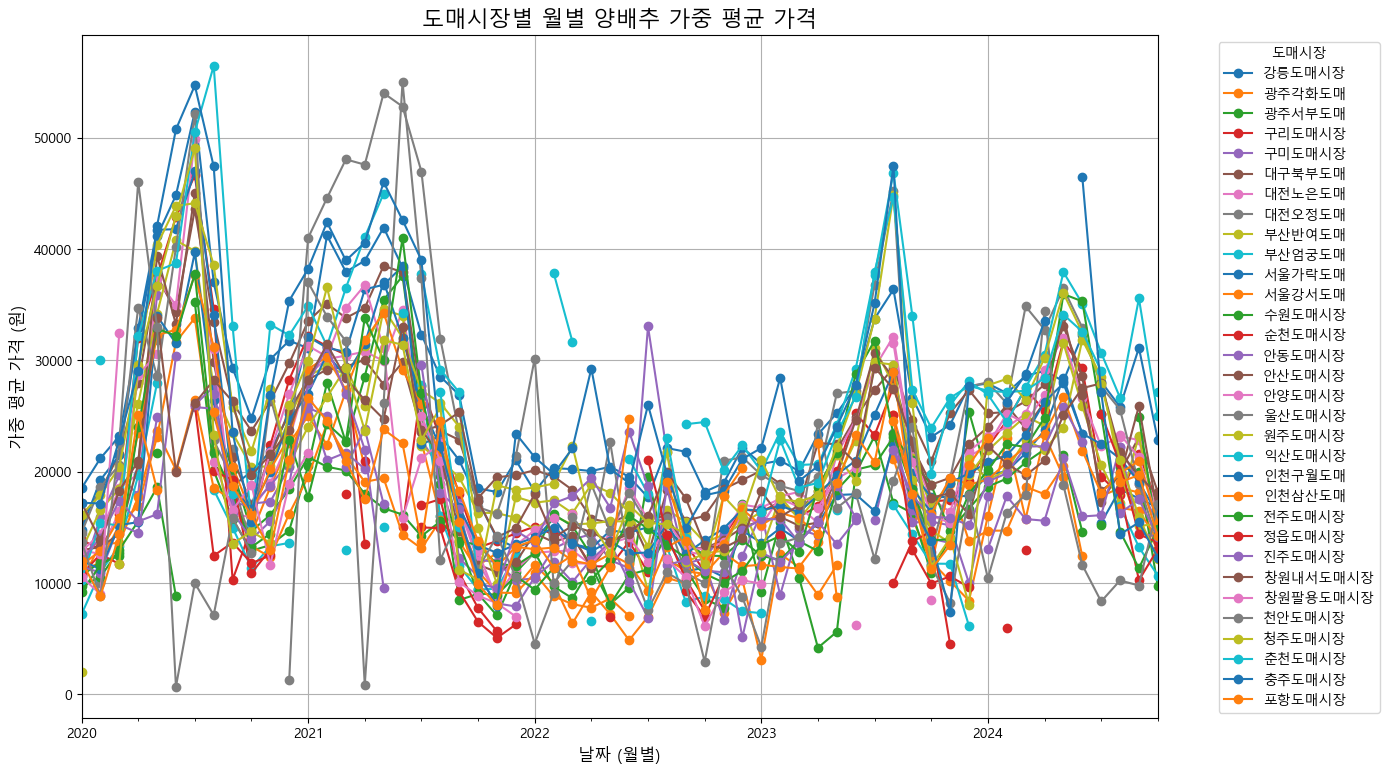

In [11]:
#도매시장별 월별 가격 시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market.pivot(index='DATE', columns='도매시장', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

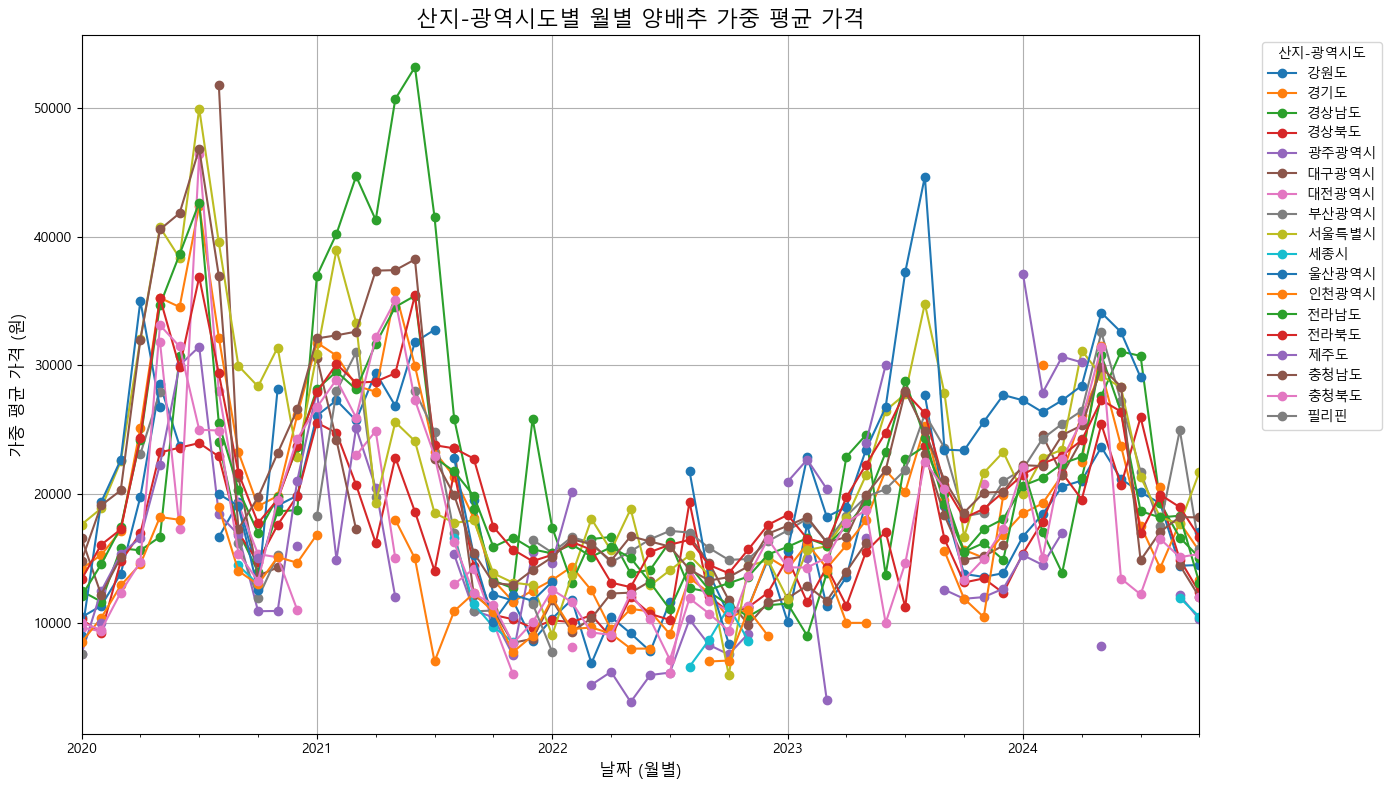

In [12]:
#광역시도별 월별 가격시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

weighted_avg_ragion = weighted_avg_ragion[weighted_avg_ragion['산지-광역시도'] != '-']

cabbage_ragion_pivot = weighted_avg_ragion.pivot(index='DATE', columns='산지-광역시도', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_ragion_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('산지-광역시도별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='산지-광역시도', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [162]:
# cabbage_df_cleaned.to_csv("data-files/cabbage_df_cleaned.csv", index=False)

In [13]:
# 기후 데이터 가져오기

weather_final = pd.read_csv("data-files/weather_final.csv")

In [14]:
weather_final

,광역시도,평균기온,평균풍속,평균강수량,DATE
0,강원도,-3.48,2.06,2.07,2019-01
1,강원도,-1.12,1.82,22.44,2019-02
2,강원도,4.30,2.18,41.57,2019-03
3,강원도,9.15,2.13,55.95,2019-04
4,강원도,16.84,2.24,18.88,2019-05
...,...,...,...,...,...
1193,충청북도,22.34,1.27,118.63,2024-06
1194,충청북도,25.83,1.41,449.82,2024-07
1195,충청북도,27.35,1.10,67.85,2024-08
1196,충청북도,23.90,1.08,233.70,2024-09


In [15]:
weather_final['DATE'] = pd.to_datetime(weather_final['DATE'], format='%Y-%m')

In [17]:
merged_df = sp_bam_cleaned.merge(weather_final, on='DATE', how='inner')

In [18]:
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], format='%Y-%m')

In [19]:
# merged_df.to_csv("data-files/merged_df.csv", index = False)

In [20]:
merged_df

,DATE,거래단위,평균가격,총거래물량,총거래금액,도매시장,도매법인,품목,품종,산지-광역시도,산지-시군구,등급,weighted_price,광역시도,평균기온,평균풍속,평균강수량
0,2024-10-01,10kg상자,17486.370609,254230,444556000,서울가락도매,중앙청과,고구마,밤고구마,전라북도,익산시,특,4.445560e+09,강원도,12.93,1.56,130.36
1,2024-10-01,10kg상자,17486.370609,254230,444556000,서울가락도매,중앙청과,고구마,밤고구마,전라북도,익산시,특,4.445560e+09,경기도,14.59,1.06,76.26
2,2024-10-01,10kg상자,17486.370609,254230,444556000,서울가락도매,중앙청과,고구마,밤고구마,전라북도,익산시,특,4.445560e+09,경상남도,16.97,1.67,154.88
3,2024-10-01,10kg상자,17486.370609,254230,444556000,서울가락도매,중앙청과,고구마,밤고구마,전라북도,익산시,특,4.445560e+09,경상북도,15.24,1.35,96.98
4,2024-10-01,10kg상자,17486.370609,254230,444556000,서울가락도매,중앙청과,고구마,밤고구마,전라북도,익산시,특,4.445560e+09,광주광역시,16.32,1.40,109.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170114,2020-01-01,10kg상자,2000.000000,10,2000,광주서부도매,호남청과,고구마,밤고구마,전라북도,남원시,특,2.000000e+04,전라남도,4.65,2.77,77.65
170115,2020-01-01,10kg상자,2000.000000,10,2000,광주서부도매,호남청과,고구마,밤고구마,전라북도,남원시,특,2.000000e+04,전라북도,2.04,1.94,83.95
170116,2020-01-01,10kg상자,2000.000000,10,2000,광주서부도매,호남청과,고구마,밤고구마,전라북도,남원시,특,2.000000e+04,제주도,6.06,3.90,163.16
170117,2020-01-01,10kg상자,2000.000000,10,2000,광주서부도매,호남청과,고구마,밤고구마,전라북도,남원시,특,2.000000e+04,충청남도,2.49,2.20,56.46


In [22]:
# 각 재배 방식에 대한 파종 시기와 수확 시기 정의
cultivation_periods = {
    "봄 재배": {"planting": [4, 5, 6, 7, 8, 9], "harvesting": [9, 10, 11]},
    
}

# 각 재배 방식에 대한 상관관계 결과를 저장할 딕셔너리
results = {}

for crop, periods in cultivation_periods.items():
    planting_months = periods['planting']  # 파종 시기 월 정의
    harvesting_months = periods['harvesting']  # 수확 시기 월 정의
    
    # 파종 시기 기후 데이터를 연도별로 집계
    planting_climate_data = (
        merged_df[merged_df['DATE'].dt.month.isin(planting_months)]
        .groupby(merged_df['DATE'].dt.year)
        .mean(numeric_only=True)[['평균기온', '평균풍속', '평균강수량']]
        .rename_axis('YEAR')  # 연도를 인덱스로 사용
    )
    
    # 수확 시기 총 거래물량을 연도별로 집계
    harvesting_transaction_data = (
        merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]
        .groupby(merged_df['DATE'].dt.year)['총거래물량']
        .sum()
        .rename_axis('YEAR')  # 연도를 인덱스로 사용
    )
    
    # 상관관계 분석을 위해 데이터를 병합
    combined_analysis_data = planting_climate_data.merge(
        harvesting_transaction_data,
        left_index=True,
        right_index=True
    )
    
    # 상관관계 계산
    correlation_results = combined_analysis_data.corr().loc['총거래물량'].drop('총거래물량')
    results[crop] = correlation_results  # 결과 저장

# 결과를 하나의 데이터프레임으로 변환하여 표시
correlation_results_df = pd.DataFrame(results).transpose()

In [23]:
correlation_results_df

,평균기온,평균풍속,평균강수량
봄 재배,-0.013593,-0.462507,0.330466
